# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as f
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler ,VectorAssembler,StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark import PickleSerializer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
# Sample top 5 records
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [6]:
# Number of rows and columns
print(df.count(), len(df.columns))  

286500 18


In [7]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
df.select("page").dropDuplicates().sort("page").show(df.select("page").count(),False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Login                    |
|Logout                   |
|NextSong                 |
|Register                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Registration      |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [10]:
df.groupBy('page').count().orderBy('count').show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
| Submit Registration|    5|
|            Register|   18|
|              Cancel|   52|
|Cancellation Conf...|   52|
|    Submit Downgrade|   63|
|      Submit Upgrade|  159|
|               Error|  258|
|       Save Settings|  310|
|             Upgrade|  499|
|               About|  924|
|            Settings| 1514|
|                Help| 1726|
|           Downgrade| 2055|
|         Thumbs Down| 2546|
|              Logout| 3226|
|               Login| 3241|
|         Roll Advert| 3933|
|          Add Friend| 4277|
|     Add to Playlist| 6526|
|           Thumbs Up|12551|
+--------------------+-----+
only showing top 20 rows



In [11]:
df.select("auth").dropDuplicates().sort("auth").show()
df.select("gender").dropDuplicates().sort("gender").show()
df.select("level").dropDuplicates().sort("level").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [12]:
df.where(df.userId == "").show(5)
df.where(df.userId == "").select("page").distinct().show()
df.select("userID").distinct().count()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

226

In [13]:
# Removing anonymous users 
df = df.filter(df["userId"] != "")
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
#  different types of authorisation
df.select("auth").distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [15]:
# different types of levels
df.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [16]:
# number of unique users
df.agg(f.countDistinct('userId')).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [17]:
# Identifying churn users
churned_users = df.select(["userId"]).filter(df.page == "Cancellation Confirmation")
churned_users = churned_users.toPandas()
churned_users = churned_users.userId.tolist()
churned_users

['18',
 '32',
 '125',
 '105',
 '17',
 '143',
 '101',
 '129',
 '121',
 '51',
 '87',
 '122',
 '12',
 '58',
 '73',
 '3',
 '106',
 '103',
 '28',
 '54',
 '29',
 '70',
 '53',
 '100011',
 '100001',
 '100024',
 '100006',
 '100019',
 '100003',
 '100023',
 '100005',
 '100017',
 '100025',
 '100009',
 '100012',
 '100013',
 '100022',
 '100014',
 '100015',
 '100021',
 '100007',
 '200001',
 '200024',
 '200011',
 '200021',
 '200018',
 '200015',
 '200017',
 '200016',
 '200020',
 '300007',
 '300001']

In [18]:
churn = f.udf(lambda x :1 if x =='Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', churn("page"))

In [19]:
df.show(10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    L

In [20]:
df.groupBy('churn').agg(f.count('userId')).show()
df.groupBy(['churn', 'gender']).agg(f.count('userId')).show()

+-----+-------------+
|churn|count(userId)|
+-----+-------------+
|    1|           52|
|    0|       278102|
+-----+-------------+

+-----+------+-------------+
|churn|gender|count(userId)|
+-----+------+-------------+
|    1|     F|           20|
|    0|     M|       123544|
|    1|     M|           32|
|    0|     F|       154558|
+-----+------+-------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
# Rounded number of days from registration
def days_since_reg(x, y):
    """
    number of days since registration
    """
    sec_diff = f.when(x > y, x - y).otherwise(0)    
    return f.round(sec_diff / (24*60*60*1000))

user_days = df.withColumn(
    'days_since_reg', days_since_reg(df.ts, df.registration)
)
user_days = user_days.select("userId","days_since_reg")\
            .groupby("userId").agg(f.sum(user_days.days_since_reg).alias("days_since_reg"))
user_days.show()

+------+--------------+
|userId|days_since_reg|
+------+--------------+
|100010|       12587.0|
|200002|       23514.0|
|   125|         781.0|
|    51|       26450.0|
|   124|      477451.0|
|     7|        9208.0|
|    54|      303053.0|
|    15|       57096.0|
|   155|       12167.0|
|   132|      115510.0|
|   154|        1168.0|
|100014|       17884.0|
|   101|       99228.0|
|    11|       86704.0|
|   138|      106760.0|
|300017|      180125.0|
|    29|      131534.0|
|    69|       60971.0|
|100021|       15463.0|
|    42|      158175.0|
+------+--------------+
only showing top 20 rows



In [22]:
# Numer of songs played 
numSongs = df.select("userId","song").groupby("userId")\
          .agg(f.count(df.song).alias("numSongs"))
numSongs.show()

+------+--------+
|userId|numSongs|
+------+--------+
|100010|     275|
|200002|     387|
|   125|       8|
|    51|    2111|
|   124|    4079|
|     7|     150|
|    54|    2841|
|    15|    1914|
|   155|     820|
|   132|    1928|
|   154|      84|
|100014|     257|
|   101|    1797|
|    11|     647|
|   138|    2070|
|300017|    3632|
|    29|    3028|
|    69|    1125|
|100021|     230|
|    42|    3573|
+------+--------+
only showing top 20 rows



In [23]:
# Average Number of Songs per session
avg_songs_session = df.where((df.page == 'NextSong')).groupBy('userID', 'sessionId') \
                    .agg(f.count(df.song).alias("num_songs"))
avg_songs_session = avg_songs_session.groupBy('userID').agg(f.avg(avg_songs_session.num_songs).alias("avg_sess_songs"))

avg_songs_session.show()

+------+------------------+
|userID|    avg_sess_songs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
|     7|21.428571428571427|
|    54| 81.17142857142858|
|    15|136.71428571428572|
|   155|136.66666666666666|
|100014|42.833333333333336|
|   132|             120.5|
|   154|              28.0|
|   101|             179.7|
|    11|           40.4375|
|300017|59.540983606557376|
|   138|             138.0|
|    29| 89.05882352941177|
|    69|             125.0|
|100021|              46.0|
|    42| 87.14634146341463|
+------+------------------+
only showing top 20 rows



In [24]:
# Total play time as per user
totalPlayTime = df.where(df["page"] == "NextSong").select("userId","length")\
                        .groupby("userId").agg(f.sum(df.length).alias("totalPlayTime"))
totalPlayTime.show()

+------+------------------+
|userId|     totalPlayTime|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
|     7| 38034.08710000002|
|    54| 711344.9195400011|
|    15|477307.60581000015|
|   155|       198779.2919|
|   132| 483118.9038399997|
|   154|20660.023910000007|
|100014| 67703.47208000004|
|   101| 447464.0146699989|
|    11|159669.96303999983|
|   138| 512449.8827599989|
|300017| 897406.9802100015|
|    29| 754517.5625700009|
|    69| 286064.0256399999|
|100021| 57633.17563999999|
|    42| 881792.9661300007|
+------+------------------+
only showing top 20 rows



In [25]:
# Average number of clicks per user
num_clicks = df.groupBy(['userId', 'page']).agg(f.count(df.page).alias('clicks'))
avgClicks = num_clicks.groupBy('userId').agg(f.avg(num_clicks.clicks).alias('avgClicks'))
avgClicks.show()

+------+------------------+
|userId|         avgClicks|
+------+------------------+
|200002|33.857142857142854|
|100010| 34.63636363636363|
|   125|              2.75|
|    51|164.26666666666668|
|   124|344.64285714285717|
|     7|15.461538461538462|
|    54|180.89473684210526|
|    15|162.71428571428572|
|   155|              66.8|
|   132|             144.0|
|100014|23.846153846153847|
|   154|             14.75|
|    11| 49.88235294117647|
|   101|119.38888888888889|
|   138|          154.3125|
|300017| 316.2857142857143|
|    29|211.94117647058823|
|100021| 24.53846153846154|
|    69|            83.875|
|    42|          266.0625|
+------+------------------+
only showing top 20 rows



In [26]:
# UserId and churn label
user_churn = df.select("userId","churn").dropDuplicates()

# Convert gender to binary 
user_male = df.select("userId","gender").withColumn('gender_male', f.when(df.gender == 'M', 1).otherwise(0))
user_male = user_male.groupBy("userId").agg(f.first('gender_male').alias("gender_male"))

# Convert subscription to binary 
user_paid = df.select("userId","level").withColumn('paid_level', f.when(df.level == 'paid', 1).otherwise(0))
user_paid = user_paid.groupBy("userId").agg(f.first('paid_level').alias("paid_level"))

user_churn.show(5)
user_male.show(5)
user_paid.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    73|    0|
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
+------+-----+
only showing top 5 rows

+------+-----------+
|userId|gender_male|
+------+-----------+
|100010|          0|
|200002|          1|
|   125|          1|
|    51|          1|
|   124|          0|
+------+-----------+
only showing top 5 rows

+------+----------+
|userId|paid_level|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         0|
|    51|         1|
|   124|         1|
+------+----------+
only showing top 5 rows



In [27]:
# joining all features
total_features_df = user_days.join(numSongs, "userId","outer" )\
                    .join(avg_songs_session, "userId","outer")\
                    .join(totalPlayTime, "userId","outer")\
                    .join(avgClicks, "userId","outer")\
                    .join(user_churn, "userId","outer")\
                    .join(user_male, "userId","outer")\
                    .join(user_paid, "userId","outer").drop("userId").fillna(0)
total_features_df.show()

+--------------+--------+------------------+------------------+------------------+-----+-----------+----------+
|days_since_reg|numSongs|    avg_sess_songs|     totalPlayTime|         avgClicks|churn|gender_male|paid_level|
+--------------+--------+------------------+------------------+------------------+-----+-----------+----------+
|       12587.0|     275|39.285714285714285| 66940.89735000003| 34.63636363636363|    0|          0|         0|
|       23514.0|     387|              64.5| 94008.87593999993|33.857142857142854|    0|          1|         0|
|         781.0|       8|               8.0|2089.1131000000005|              2.75|    1|          1|         0|
|         781.0|       8|               8.0|2089.1131000000005|              2.75|    0|          1|         0|
|      477451.0|    4079|145.67857142857142|1012312.0927899999|344.64285714285717|    0|          0|         1|
|       26450.0|    2111|             211.1| 523275.8428000004|164.26666666666668|    1|          1|    

In [28]:
file = "total_features_df.csv"
total_features_df.write.save(file, format="csv", header=True, mode='overwrite')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [29]:
total_features_df = spark.read.csv("total_features_df.csv", header=True)
total_features_df.persist()

DataFrame[days_since_reg: string, numSongs: string, avg_sess_songs: string, totalPlayTime: string, avgClicks: string, churn: string, gender_male: string, paid_level: string]

In [30]:
# reading csv convert all columns to string
total_features_df.printSchema()

root
 |-- days_since_reg: string (nullable = true)
 |-- numSongs: string (nullable = true)
 |-- avg_sess_songs: string (nullable = true)
 |-- totalPlayTime: string (nullable = true)
 |-- avgClicks: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender_male: string (nullable = true)
 |-- paid_level: string (nullable = true)



In [31]:
# converting each columns to float
total_features_df = total_features_df.select(*(f.col(c).cast("float").alias(c) for c in total_features_df.columns))
total_features_df.printSchema()

root
 |-- days_since_reg: float (nullable = true)
 |-- numSongs: float (nullable = true)
 |-- avg_sess_songs: float (nullable = true)
 |-- totalPlayTime: float (nullable = true)
 |-- avgClicks: float (nullable = true)
 |-- churn: float (nullable = true)
 |-- gender_male: float (nullable = true)
 |-- paid_level: float (nullable = true)



In [32]:
# total_features_df = total_features_df.drop("userId")
feature_cols = total_features_df.columns
feature_cols.remove('churn')

assembler = VectorAssembler().setInputCols(feature_cols).setOutputCol("features")
total_features_df = assembler.transform(total_features_df)

train_df, test_df = total_features_df.randomSplit([0.7, 0.3], seed=31)

In [33]:
def model_eval(model_type, model, test_data, train_data):

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn", metricName="f1")
    evaluator.setMetricName("f1")
    
    train_predictions = model.transform(train_data)
    test_predictions = model.transform(test_data)
    results = {}
    results["model"] = model_type
    results["f1_train"] = round(evaluator.evaluate(train_predictions, {evaluator.metricName:"f1"}),6)
    results["f1_test"] = round(evaluator.evaluate(test_predictions, {evaluator.metricName:"f1"}),6)
    results["precision_train"] = round(evaluator.evaluate(train_predictions, {evaluator.metricName:"weightedPrecision"}),6)
    results["precision_test"] = round(evaluator.evaluate(test_predictions, {evaluator.metricName:"weightedPrecision"}),6)
    results["recall_train"] = round(evaluator.evaluate(train_predictions, {evaluator.metricName:"weightedRecall"}),6)
    results["recall_test"] = round(evaluator.evaluate(test_predictions, {evaluator.metricName:"weightedRecall"}),6)
    results["accuracy_train"] = round(evaluator.evaluate(train_predictions, {evaluator.metricName:"accuracy"}),6)
    results["accuracy_test"] = round(evaluator.evaluate(test_predictions, {evaluator.metricName:"accuracy"}),6)

    return results

In [34]:
def model_train(model_type, train, test):
    
    stages = []
    scaler = StandardScaler(inputCol="features", outputCol="scaledColumns")
    stages.append(scaler)
 
    evaltr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn", metricName="f1")

    if model_type == "LogisticRegression":
        classifier = LogisticRegression(featuresCol = "features", labelCol = "churn")
        
        param_grid = ParamGridBuilder().addGrid(classifier.maxIter, [50, 100, 150, 200]) \
                                       .addGrid(classifier.threshold, [0.4, 0.5, 0.6, 0.7]).build()
        
    elif model_type == "RandomForest":
        classifier = RandomForestClassifier(featuresCol = "features", labelCol = "churn",
                                            featureSubsetStrategy="auto", impurity='gini')

        param_grid = ParamGridBuilder().addGrid(classifier.numTrees, [3, 4, 5, 6, 7]) \
                                       .addGrid(classifier.maxDepth, [5, 10, 15, 20]).build()
    
    elif model_type == "GradientBoostedTree":
        classifier = GBTClassifier(featuresCol = "features", labelCol = "churn")

        param_grid = ParamGridBuilder().addGrid(classifier.maxIter, [10, 20, 30, 40]) \
                                       .addGrid(classifier.maxDepth, [5, 10, 20, 30]).build()
 
    cv = CrossValidator(estimator = classifier,estimatorParamMaps = param_grid,
                        evaluator = evaltr,numFolds=50)

    stages.append(classifier)    
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(train)
    
    return model_eval(model_type, model, test, train)

In [35]:
lr_results = model_train('LogisticRegression', train_df, test_df)
lr_results

{'model': 'LogisticRegression',
 'f1_train': 0.768818,
 'f1_test': 0.709235,
 'precision_train': 0.753084,
 'precision_test': 0.753785,
 'recall_train': 0.81592,
 'recall_test': 0.776316,
 'accuracy_train': 0.81592,
 'accuracy_test': 0.776316}

In [36]:
rf_results = model_train('RandomForest', train_df, test_df)
rf_results

{'model': 'RandomForest',
 'f1_train': 0.765804,
 'f1_test': 0.654135,
 'precision_train': 0.86291,
 'precision_test': 0.58,
 'recall_train': 0.835821,
 'recall_test': 0.75,
 'accuracy_train': 0.835821,
 'accuracy_test': 0.75}

In [37]:
gb_results = model_train('GradientBoostedTree', train_df, test_df)
gb_results

{'model': 'GradientBoostedTree',
 'f1_train': 0.866467,
 'f1_test': 0.559649,
 'precision_train': 0.883641,
 'precision_test': 0.541596,
 'recall_train': 0.885572,
 'recall_test': 0.578947,
 'accuracy_train': 0.885572,
 'accuracy_test': 0.578947}

In [38]:
spark.read.json(spark.sparkContext.parallelize([lr_results, rf_results, gb_results])) \
    .select("model","f1_train","f1_test","precision_train","precision_test",
            "recall_train","recall_test","accuracy_train","accuracy_test").show()

+-------------------+--------+--------+---------------+--------------+------------+-----------+--------------+-------------+
|              model|f1_train| f1_test|precision_train|precision_test|recall_train|recall_test|accuracy_train|accuracy_test|
+-------------------+--------+--------+---------------+--------------+------------+-----------+--------------+-------------+
| LogisticRegression|0.768818|0.709235|       0.753084|      0.753785|     0.81592|   0.776316|       0.81592|     0.776316|
|       RandomForest|0.765804|0.654135|        0.86291|          0.58|    0.835821|       0.75|      0.835821|         0.75|
|GradientBoostedTree|0.866467|0.559649|       0.883641|      0.541596|    0.885572|   0.578947|      0.885572|     0.578947|
+-------------------+--------+--------+---------------+--------------+------------+-----------+--------------+-------------+



In [39]:
results_df = pd.DataFrame({'score': [lr_results['f1_train'], rf_results['f1_train'], gb_results['f1_train'],
                                     lr_results['f1_test'], rf_results['f1_test'], gb_results['f1_test']],
                           'dataset': ['Train', 'Train', 'Train', 'Test', 'Test', 'Test'],
                           'model': ['LogisticRegression', 'RandomForest', 'GradientBoosting',
                                     'LogisticRegression', 'RandomForest', 'GradientBoosting']})

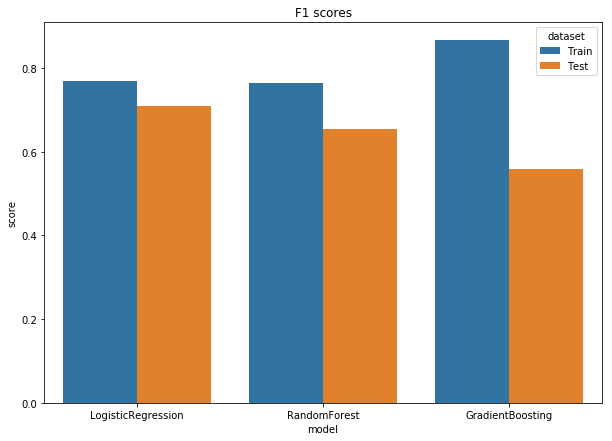

In [45]:
plt.figure(figsize=(10,7))
sns.barplot(x='model', y='score', hue='dataset', data=results_df)
plt.title('F1 scores')
plt.show()

<b>As per F1 score evaluation metric, LogisticRegression is the optimal model to predict churn because it has the highest F1 score.</b>

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.